In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os

In [2]:
root = "../data/"
filename = 'javi_measurements.csv' 
data_file = os.path.join(root, filename)
!head $data_file

In [3]:
columns = 'Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades)'
columns = columns.split(',')

df = pd.read_csv(data_file, sep=',', header=None, names=columns, low_memory=False)
df.drop(df.index[0], inplace=True)
df.head()

,Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades)
1,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 5:40 pm,0,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 5:55 pm,0,159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:10 pm,0,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:25 pm,0,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:40 pm,0,147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.describe()

,Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades)
count,103357,103357,103357,103357,93657,9693,0.0,4,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0
unique,2,8,83564,3,457,405,0.0,4,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
top,FreeStyle LibreLink,c5f89737-15cc-4361-8788-d4c019a08f78,12-28-2017 6:12 am,0,173,75,NaN,"9,0",NaN,NaN,NaN,NaN,"10,0",NaN,NaN,NaN,NaN,NaN,NaN
freq,52067,40897,4,93657,480,66,NaN,1,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dfs = df[['Sello de tiempo del medidor', 'Historial de glucosa(mg/dL)', 'Escaneo de glucosa(mg/dL)']]
dfs.columns = ['timestamp', 'aut_record', 'man_record']

In [6]:
dfs.head()

,timestamp,aut_record,man_record
1,06-06-2017 5:40 pm,156,NaN
2,06-06-2017 5:55 pm,159,NaN
3,06-06-2017 6:10 pm,170,NaN
4,06-06-2017 6:25 pm,164,NaN
5,06-06-2017 6:40 pm,147,NaN


In [7]:
dfs = dfs.dropna(inplace=False, subset=['aut_record']).reset_index()

In [8]:
dfs.head()

,index,timestamp,aut_record,man_record
0,1,06-06-2017 5:40 pm,156,NaN
1,2,06-06-2017 5:55 pm,159,NaN
2,3,06-06-2017 6:10 pm,170,NaN
3,4,06-06-2017 6:25 pm,164,NaN
4,5,06-06-2017 6:40 pm,147,NaN


In [9]:
dfs.aut_record = dfs.aut_record.values.astype(np.int)

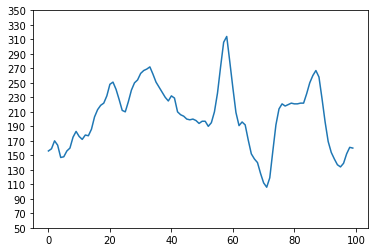

In [10]:
plt.figure()
plt.plot(dfs.aut_record.values[:100])
yaxis = np.arange(50, 360, step=20)
plt.yticks(yaxis, yaxis)
plt.show()

In [11]:
import datetime

In [12]:
dfs.timestamp = pd.to_datetime(dfs.timestamp, infer_datetime_format=True)

In [13]:
dfs.head()

,index,timestamp,aut_record,man_record
0,1,2017-06-06 17:40:00,156,NaN
1,2,2017-06-06 17:55:00,159,NaN
2,3,2017-06-06 18:10:00,170,NaN
3,4,2017-06-06 18:25:00,164,NaN
4,5,2017-06-06 18:40:00,147,NaN


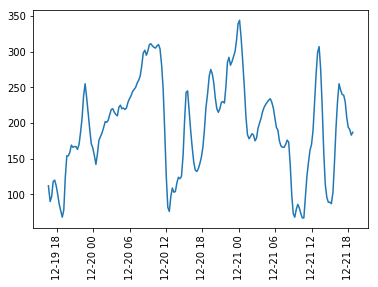

In [14]:
plt.figure()
start=np.random.randint(low=0, high=dfs.index.size)
N = 200
plt.plot(dfs.timestamp.values[start:start+N], dfs.aut_record.values[start:start+N])
plt.gcf().canvas.draw()

ax = plt.gca()
label = ax.get_xticklabels()
label = [l.get_text() for l in label]
ax.set_xticklabels(label, rotation=90)
plt.show()

In [15]:
one_day = np.timedelta64(1000000000*3600*24, 'ns')
one_hour = np.timedelta64(1000000000*3600, 'ns')

def create_sequence(data, start, history, future, time_unit=one_day, noise=0.1):
    # get feature and label index ranges
    feature_range = np.arange(start, start+history)
    label_range = np.arange(start+history, start+history+future)
    
    # get time feature, substract last time feature event, and normalize to time_unit
    ts_feature = data.timestamp.values[feature_range]
    zero_time = ts_feature[-1]
    ts_feature = [(ts-zero_time)/time_unit for ts in ts_feature]
    # get sugar level feature, and min-max normalize
    ys_feature = data.aut_record.values[feature_range].astype(np.float)
    min_ys = np.min(ys_feature)
    max_ys = np.max(ys_feature)
    ys_feature = (ys_feature-min_ys) / (max_ys - min_ys)
    
    # get time label, substract last time feature event, and normalize to time_unit
    ts_label = data.timestamp.values[label_range]
    ts_label = [(ts-zero_time)/time_unit for ts in ts_label]
    # get sugar level label, and min-max normalize
    ys_label = data.aut_record.values[label_range]
    ys_label = (ys_label-min_ys) / (max_ys - min_ys)
    
    # add noise to sugar level feature sequence
    if noise > 0.0:
        noisy_seq = np.random.normal(loc=0.0, scale=noise, size=ys_feature.size)
        ys_feature_noisy = ys_feature + noisy_seq
    else:
        ys_feature_noisy = ys_feature.copy()
    return ts_feature, ts_label, ys_feature, ys_feature_noisy, ys_label

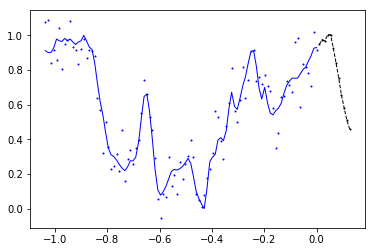

In [16]:
plt.figure()
start=np.random.randint(low=0, high=dfs.index.size)
history = 100  # a history of 25 h 
future = 12  # this accounts for a prediction of 3 hours in advance
xf, xl, yf, ynf, yl = create_sequence(dfs, start=start, history=history, future=future, 
                                      time_unit=one_day, noise=0.1)
plt.plot(xf, yf, '-b', markersize=2, linewidth=1)
plt.plot(xf, ynf, '.b', markersize=2, linewidth=1)
plt.plot(xl, yl, '.--k', markersize=2, linewidth=1)

plt.show()

In [17]:
def create_dataset(data, num_samples, min_idx, max_idx, history, future, replace=False,
                   noise=0.1, time_unit=one_day, time_tolerance=1.2, seed=1098):
    indices = data.index[min_idx: max_idx-history-future+1]
    np.random.seed(seed)
    starts = np.random.choice(indices, size=num_samples, replace=replace)
    out = np.zeros(shape=(num_samples, 2*(history+future)), dtype=np.float32)
    max_time = history*0.25*one_hour/one_day
    k = 0
    for i, start in enumerate(starts):
        xf, xl, _, ynf, yl = create_sequence(data, start=start, history=history, 
                                              future=future, time_unit=one_day, noise=noise)
        if -np.min(xf)/max_time < time_tolerance:
            out[k] = np.concatenate([xf, xl, ynf, yl], axis=0)
            k += 1
        else: 
            out = np.delete(out, k, 0)
    s = "%s sequences (out of %s) couldn't been added because they exceed "
    s += "the maximum attainable time (%0.2f)" 
    print(s %(i-k, k, max_time))
    return out

In [18]:
size = dfs.shape[0]
history = 100
future = 12
train_max_idx = int(size*0.9)
seed = 178
noise = 0.07
tol = 1.1
replace = True
if replace:
    num_samples = 4*train_max_idx
else:
    num_samples = train_max_idx-history-future
train_vad = create_dataset(dfs, num_samples=num_samples, min_idx=0, 
                       max_idx=train_max_idx, history=history, future=future, replace=replace,
                       noise=noise, time_unit=one_day, time_tolerance=tol, seed=seed)

17879 sequences (out of 319284) couldn't been added because they exceed the maximum attainable time (1.04)


In [19]:
# get validation data randomly from the generated train set
np.random.seed(seed)
vad_idx = np.random.choice(np.arange(train_vad.shape[0]), int(size*0.1), replace=False)
mask = np.ones(train_vad.shape[0],dtype=bool) 
mask[vad_idx] = False
vad = train_vad[~mask, :]
train = train_vad[mask, :]
print(train_vad.shape, train.shape, vad.shape)

(319284, 224) (309919, 224) (9365, 224)


In [20]:
# testing set
test = create_dataset(dfs, num_samples=size-train_max_idx-history-future, 
                      min_idx=train_max_idx, max_idx=size, history=history, 
                      future=future, replace=False, noise=0.0, time_unit=one_day, 
                      time_tolerance=tol, seed=seed)
print(test.shape[0])

472 sequences (out of 8781) couldn't been added because they exceed the maximum attainable time (1.04)
8781


(224,) (100,) (12,) (100,) (12,)


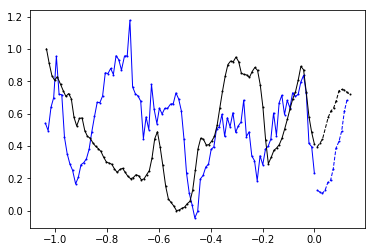

In [21]:
plt.figure()
idx=np.random.randint(low=0, high=train.shape[0])
xf, xl = train[idx, :history], train[idx, history:history+future]
yf, yl = train[idx, history+future:2*history+future], train[idx, 2*history+future:]
print(train[idx, :].shape, xf.shape, xl.shape, yf.shape, yl.shape)
plt.plot(xf, yf, '.-b', markersize=2, linewidth=1)
plt.plot(xl, yl, '.--b', markersize=2, linewidth=1)

idx=np.random.randint(low=0, high=test.shape[0])
xf, xl = test[idx, :history], test[idx, history:history+future]
yf, yl = test[idx, history+future:2*history+future], test[idx, 2*history+future:]
plt.plot(xf, yf, '.-k', markersize=2, linewidth=1)
plt.plot(xl, yl, '.--k', markersize=2, linewidth=1)

plt.show()

In [22]:
np.save(os.path.join(root, "noisy%s_train.npy" %noise), train)
np.save(os.path.join(root, "noisy%s_vad.npy" %noise), vad)
np.save(os.path.join(root, "noisy%s_test.npy" %noise), test)